In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import keras
import subprocess
import tf2onnx
import onnxruntime as rt

from collections import deque
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# Aknowledgements
Implementation based on code by Maciej Balawejder

[[Medium post](https://medium.com/analytics-vidhya/solving-open-ais-cartpole-using-reinforcement-learning-part-2-73848cbda4f1)]

[[Github](https://github.com/maciejbalawejder/Reinforcement-Learning-Collection/tree/main/DQN)]

# Classes

In [2]:
class Model:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create()
        self.Qtarget.set_weights(self.Qpolicy.get_weights())

    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.input_dim, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.output_dim, activation='linear'))
        model.compile(optimizer=RMSprop(lr=self.lr, rho=0.95,
                      epsilon=0.01), loss="mse", metrics=['accuracy'])
        return model


class DQNAgent:
    def __init__(self, lr=2.5e-4, gamma=0.99, epsilon=1, decay_coe=0.99975, min_eps=0.001,
                 batch_size=64, memory_size=10_000, episodes=5_000, C=5):

        self.env = gym.make('CartPole-v0')

        self.states = len(self.env.observation_space.low)
        self.n_actions = self.env.action_space.n

        self.actions = [i for i in range(self.n_actions)]

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_coe = decay_coe
        self.min_eps = min_eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.D = deque(maxlen=memory_size)  # replay memory
        self.C = C

        self.terminal_state = False  # end of the episode
        self.target_counter = 0

        # Plot data
        self.timestep = self.episodes / 10
        self.history = []
        self.reward_data = []
        self.epsilon_data = []

        self.model = Model(self.states, self.n_actions, self.lr)
        # Smooth epsilon
        self.a = 0.35
        self.b = 0.1
        self.c = 0.01

    def state_shape(self, states):
        states = np.array(states)
        return states.reshape(-1, *states.shape)

    def decrement_epsilon(self, time):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        s_time = (time - self.a*self.episodes) / (self.b*self.episodes)
        cosh = np.cosh(math.exp(-s_time))
        self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))

    def update_D(self, s, a, r, s_, done):
        self.D.append([self.state_shape(s), a, r, self.state_shape(s_), done])

    def choose_action(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))

        return action

    def minibatch(self):
        return random.sample(self.D, self.batch_size)

    def graphs(self, episode):
        f1 = plt.figure(1)
        plt.plot([i for i in range(len(self.reward_data))], self.reward_data)
        plt.ylabel('Score per episode')
        plt.xlabel('Episodes')
        plt.savefig(r'./training/reward - e{}v2.png'.format(episode), dpi=500)

        f2 = plt.figure(2)
        plt.plot([i for i in range(len(self.epsilon_data))], self.epsilon_data)
        plt.ylabel('Epsilon')
        plt.xlabel('Episodes')
        plt.savefig(r'./training/epsilon - e{}v2.png'.format(episode), dpi=500)

        f3 = plt.figure(3)
        plt.plot([i for i in range(len(self.history))], self.history)
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        plt.savefig(r'./training/loss - e{}v2.png'.format(episode), dpi=500)

    def train(self):
        ### Creates 'training' directory if it doesn't exist
        subprocess.run(['mkdir', '-p', './training/'])

        # X - states passed to the NN, y - target

        X, y = [], []

        if len(self.D) >= self.batch_size:
            SARS = self.minibatch()

            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * \
                        np.max(future_qvalue[index])

                qcurr = qvalue[index][0]
                qcurr[action] = Qtarget
                X.append(state)
                y.append(qcurr)

            X, y = np.array(X).reshape(1, self.batch_size, 1, self.states), np.array(
                y).reshape(1, self.batch_size, 1, self.n_actions)

            loss = self.model.Qpolicy.fit(
                X, y, batch_size=self.batch_size, shuffle=False, verbose=0)
            self.history.append(loss.history['loss'][0])

            if self.terminal_state:
                self.target_counter += 1

            # C -> target network update frequency
            if self.target_counter > self.C:
                self.model.Qtarget.set_weights(
                    self.model.Qpolicy.get_weights())
                self.target_counter = 0

    def training(self):
        timestep_reward = 0

        for episode in tqdm(range(1, self.episodes+1), ascii=True, unit='episode'):
            s = self.env.reset()
            done = False
            score = 0
            while done != True:
                a = self.choose_action(s)

                s_, r, done, _ = self.env.step(a)

                # Update
                self.terminal_state = done
                self.update_D(s, a, r, s_, done)

                self.train()

                s = s_
                score += r

            self.decrement_epsilon(episode)

            # UPDATE
            self.reward_data.append(score)
            self.epsilon_data.append(self.epsilon)

            if episode % self.timestep == 0:
                self.graphs(episode)

        self.graphs(episode)
        self.model.Qpolicy.save('./training/saved_qpolicy.h5')


# Functions

In [3]:
def test(model_name, test_episodes=100, savefig=False):
    model = tf.keras.models.load_model('{}'.format(model_name))
    reward = []
    env = gym.make('CartPole-v0')
    for i in tqdm(range(test_episodes)):
        ep_reward = 0
        s = env.reset()
        done = False

        while done != True:
            env.render()
            a = np.argmax(model.predict(np.array([s])))
            s_, r, done, _ = env.step(a)
            s = s_
            ep_reward += r
        reward.append(ep_reward)

    env.close()
    plt.plot([i for i in range(len(reward))], reward)
    plt.xlabel('Episodes')
    plt.ylabel('Episode reward')
    if savefig:
        plt.savefig(r'./training/Test.png')

# Training

In [8]:
dqn = DQNAgent(episodes = 1_000)

In [ ]:
# Train model and automatically saves it after it finish
dqn.training()

# Test model
test('./training/saved_qpolicy.h5', 10, savefig=True)

# Load model

In [15]:
saved_model = keras.models.load_model('policy_network.h5')

In [16]:
saved_model.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_325 (Dense)           (None, 512)               2560      
                                                                 
 dense_326 (Dense)           (None, 256)               131328    
                                                                 
 dense_327 (Dense)           (None, 128)               32896     
                                                                 
 dense_328 (Dense)           (None, 2)                 258       
                                                                 
Total params: 167,042
Trainable params: 167,042
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 10/10 [03:48<00:00, 22.84s/it]


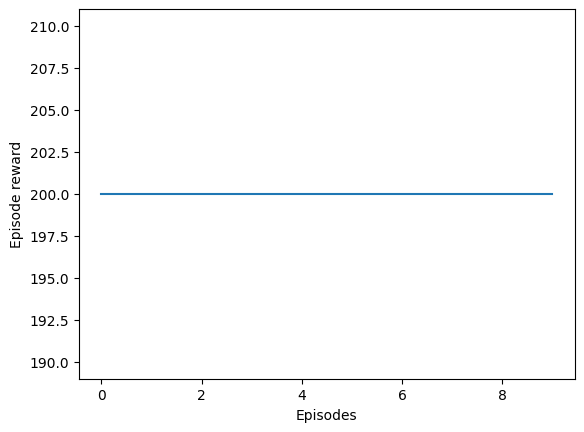

In [4]:
test('policy_network.h5', 10)

# Save in onnx

In [57]:
spec = (tf.TensorSpec((None, 4), tf.float32, name="input"),)
output_path = "policy_network.onnx"

model_proto, _ = tf2onnx.convert.from_keras(saved_model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

# Load onnx model

In [31]:
env = gym.make('CartPole-v0')
x = np.array([env.reset().astype(np.float32)])

providers = ['CPUExecutionProvider']
m = rt.InferenceSession("policy_network.onnx", providers=providers)
onnx_pred = m.run(None, {"input": x})

tf_pred = saved_model.predict(x)

print('TF Prediction:', np.argmax(tf_pred))
print('ONNX Prediction:', np.argmax(onnx_pred[0]))

### Make sure ONNX and keras have the same results
np.testing.assert_allclose(tf_pred, onnx_pred[0], rtol=1e-5)

TF Prediction: 1
ONNX Prediction: 1
